In [1]:
#importing os, shutil and glob for copying concrete images from raw folder to the new structure which is 
#required for ImageDataGenerator.flow_from_directory
import os
import shutil
import glob
import cv2
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
%matplotlib inline

#import keras and different type of layers for for defining CNN models
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.metrics import Precision, Recall

from sklearn.decomposition import PCA

Using TensorFlow backend.
C:\Users\amitv\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\amitv\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\amitv\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\amitv\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
def getDataDic(size):
    baseDir = 'data_' + size + 'k/'
    dic = {}
    train_crack_path = os.listdir(os.path.join(baseDir, 'train/crack/'))
    train_crack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'train/crack/', path)), (32, 32)) for path in train_crack_path]
    dic['train_crack'] = train_crack

    train_uncrack_path = os.listdir(os.path.join(baseDir, 'train/uncrack/'))
    train_uncrack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'train/uncrack/', path)), (32, 32)) for path in train_uncrack_path]
    dic['train_uncrack'] = train_uncrack

    test_crack_path = os.listdir(os.path.join(baseDir, 'test/crack/'))
    test_crack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'test/crack/', path)), (32, 32)) for path in test_crack_path]
    dic['test_crack'] = test_crack

    test_uncrack_path = os.listdir(os.path.join(baseDir, 'test/uncrack/'))
    test_uncrack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'test/uncrack/', path)), (32, 32)) for path in test_uncrack_path]
    dic['test_uncrack'] = test_uncrack

    validation_crack_path = os.listdir(os.path.join(baseDir, 'validation/crack/'))
    validation_crack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'validation/crack/', path)), (32, 32)) for path in validation_crack_path]
    dic['validation_crack'] = validation_crack

    validation_uncrack_path = os.listdir(os.path.join(baseDir, 'validation/uncrack/'))
    validation_uncrack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'validation/uncrack/', path)), (32, 32)) for path in validation_uncrack_path]
    dic['validation_uncrack'] = validation_uncrack

    visualization_crack_path = os.listdir(os.path.join(baseDir, 'visualization/real_images/'))
    visualization_crack = [cv2.resize(cv2.imread(os.path.join(baseDir,'visualization/real_images/',path)), (32, 32)) for path in visualization_crack_path]
    dic['visualization_crack'] = visualization_crack
    
    return dic

In [3]:
def getHighQualityVisualizationImages(size):
    baseDir = 'data_' + size + 'k/'
    
    images_path = os.listdir(os.path.join(baseDir, 'visualization/real_images/'))
    visualization_images = [cv2.imread(os.path.join(baseDir,'visualization/real_images/',path)) for path in images_path]
    
    return visualization_images

In [4]:
def transformDataToApplyPca(dic):
    training_images_list = dic['train_crack'] + dic['train_uncrack']
    y_train = []
    for i in range(len(dic['train_crack'])):
        y_train.append(0)
    for i in range(len(dic['train_uncrack'])):
        y_train.append(1)

    testing_images_list = dic['test_crack'] + dic['test_uncrack']
    y_test = []
    for i in range(len(dic['test_crack'])):
        y_test.append(0)
    for i in range(len(dic['test_uncrack'])):
        y_test.append(1)

    validation_images_list = dic['validation_crack'] + dic['validation_uncrack']
    y_validation = []
    for i in range(len(dic['validation_crack'])):
        y_validation.append(0)
    for i in range(len(dic['validation_uncrack'])):
        y_validation.append(1)

    visualization_images_list = dic['visualization_crack']

    temp1 = list(zip(training_images_list, y_train))
    random.shuffle(temp1)
    training_images_list, y_train = zip(*temp1)

    temp2 = list(zip(testing_images_list, y_test))
    random.shuffle(temp2)
    testing_images_list, y_test = zip(*temp2)

    temp3 = list(zip(validation_images_list, y_validation))
    random.shuffle(temp3)
    validation_images_list, y_validation = zip(*temp3)

    training_images = np.array(training_images_list)
    testing_images = np.array(testing_images_list)
    validation_images = np.array(validation_images_list)
    visualization_images = np.array(visualization_images_list)
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_validation = np.array(y_validation)
    
    return (training_images, testing_images, validation_images, visualization_images, y_train, y_test, y_validation)

In [5]:
def convertImagesDataFrom3dTo1d(training_images , testing_images, validation_images, visualization_images):
    #Now let's reshape images to 1-d
    training_data = training_images.reshape((len(training_images), 32*32*3))
    testing_data = testing_images.reshape((len(testing_images), 32*32*3))
    validation_data = validation_images.reshape((len(validation_images), 32*32*3))
    visualization_data = visualization_images.reshape((len(visualization_images), 32*32*3))

    return (training_data, testing_data, validation_data, visualization_data)

In [6]:
def returnKwith99Info(variance):
    k = 0
    currentSum = 0
    total = sum(variance)
    
    while(currentSum/total) <  0.99:
        currentSum += variance[k]
        k += 1
    return k

In [7]:
def applyPcaAndFindSuitableK(training_data, testing_data, validation_data, visualization_data):
    pca = PCA()
    pca.fit(training_data)
    
    k = returnKwith99Info(pca.explained_variance_)
    
    pca = PCA(n_components=k)
    transformed_training_data = pca.fit_transform(training_data)
    
    transformed_testing_data = pca.transform(testing_data)
    transformed_validation_data = pca.transform(validation_data)
    transformed_visualization_data = pca.transform(visualization_data)
    
    return (transformed_training_data, transformed_testing_data, transformed_validation_data, transformed_visualization_data)

In [8]:
def addExtraDimForConv1D(training_data, testing_data, validation_data, visualization_data):
    training_data = np.expand_dims(training_data, axis=2)
    testing_data = np.expand_dims(testing_data, axis=2)
    validation_data = np.expand_dims(validation_data, axis=2)
    visualization_data = np.expand_dims(visualization_data, axis=2)
    
    return (training_data, testing_data, validation_data, visualization_data)

In [9]:
def getModel(k):
    model = Sequential()
    
    model.add(Conv1D(filters=6, kernel_size=5, activation='relu', input_shape=(k, 1)))
    model.add(AveragePooling1D(pool_size=2, strides=2))

    model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
    model.add(AveragePooling1D(pool_size=2, strides=2))
    
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(units=84))
    model.add(Activation('relu'))

    model.add(Dense(1)) # this our output layer (since this is binary classification of cracked or uncracked, we use only one unit in output layer).
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
    
    return model

# First let's work with 8K images
## 4K of which are with cracks and 4K of which are without cracks

In [10]:
#let's get data of 8k images of which 4k are with cracks and 4k without cracks
dic_8k = getDataDic('8')
print(len(dic_8k['train_crack']), len(dic_8k['train_uncrack']), len(dic_8k['test_crack']), len(dic_8k['test_uncrack']),
      len(dic_8k['validation_crack']), len(dic_8k['validation_uncrack']), len(dic_8k['visualization_crack']))

2800 2800 600 600 595 595 10


In [11]:
#spearate training, testing, validation and visualization images from dictionary of whole images
training_images_8k, testing_images_8k, validation_images_8k, visualization_images_8k, y_train_8k, y_test_8k, y_validation_8k = transformDataToApplyPca(dic_8k)
print('Training images = ', len(training_images_8k), ' ', len(y_train_8k))
print('Testing images = ', len(testing_images_8k), ' ', len(y_test_8k))
print('Validation images = ', len(validation_images_8k), ' ', len(y_validation_8k))
print('Visualization images = ', len(visualization_images_8k))

Training images =  5600   5600
Testing images =  1200   1200
Validation images =  1190   1190
Visualization images =  10


#### Let's Visualize Training Images before applying PCA

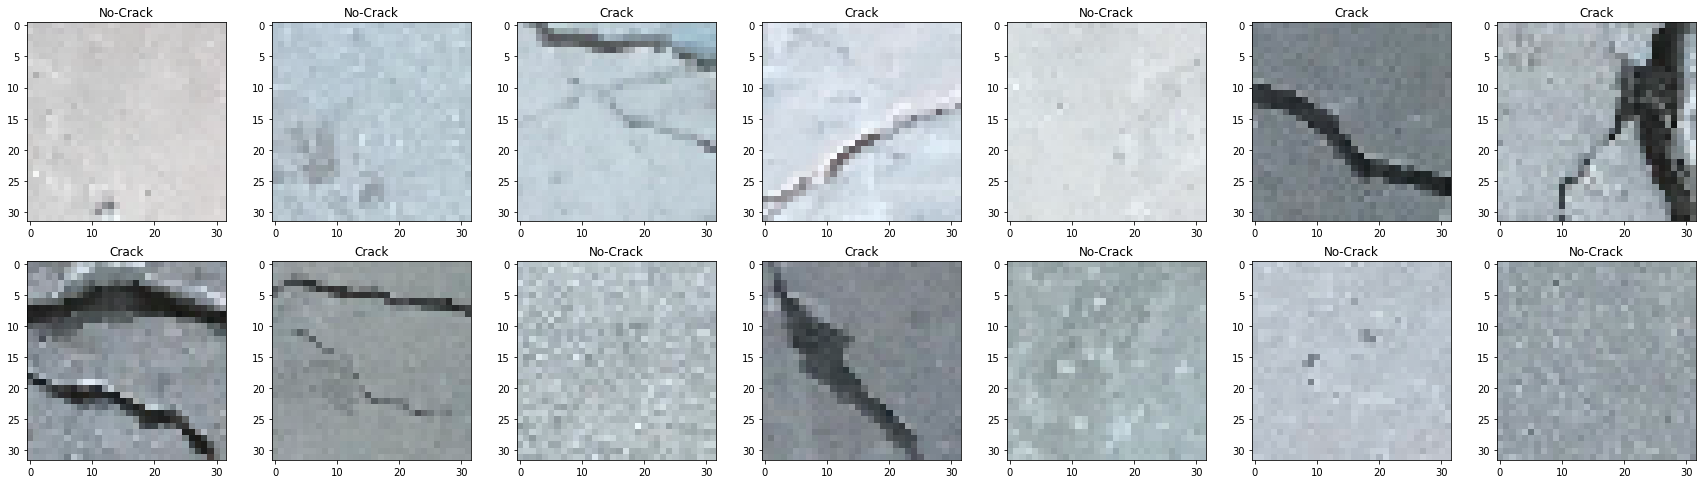

In [12]:
fig = plt.figure(figsize=(30, 30))
for i in range(0, 14, 1):
    ax = fig.add_subplot(7, 7, i+1)
    ax.imshow(training_images_8k[i])
    if(y_train_8k[i] == 0):
        ax.set_title('Crack')
    else:
        ax.set_title('No-Crack')
plt.show()

In [13]:
training_data_8k, testing_data_8k, validation_data_8k, visualization_data_8k = convertImagesDataFrom3dTo1d(training_images_8k, testing_images_8k, validation_images_8k, visualization_images_8k)


start_time_8k = time.time()
transformed_training_data_8k, transformed_testing_data_8k, transformed_validation_data_8k, transformed_visualization_data_8k = applyPcaAndFindSuitableK(training_data_8k, testing_data_8k, validation_data_8k, visualization_data_8k)
finish_time_8k = time.time()
time_taken_8k = finish_time_8k - start_time_8k
print('PCA applied in {:.0f}m {:.0f}s'.format(time_taken_8k // 60, time_taken_8k % 60))


transformed_training_data_8k, transformed_testing_data_8k, transformed_validation_data_8k, transformed_visualization_data_8k = addExtraDimForConv1D(transformed_training_data_8k, transformed_testing_data_8k, transformed_validation_data_8k, transformed_visualization_data_8k)
print('Number of features which contains 99% of total information : ', transformed_training_data_8k.shape[1])

PCA applied in 0m 19s
Number of features which contains 99% of total information :  783


In [14]:
model_8k = getModel(transformed_training_data_8k.shape[1])
model_8k.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 779, 6)            36        
_________________________________________________________________
average_pooling1d_1 (Average (None, 389, 6)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 385, 16)           496       
_________________________________________________________________
average_pooling1d_2 (Average (None, 192, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 192, 16)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 16)            0         
________________________

In [15]:
start_time = time.time() 
verbose, epochs, batch_size = 0, 15, 32
model_8k.fit(
    transformed_training_data_8k,
    y_train_8k,
    epochs=epochs,
    validation_data=(transformed_validation_data_8k, y_validation_8k)
)
finish_time = time.time()
time_taken = finish_time-start_time
print('\n')
print('Training complete in {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))


Train on 5600 samples, validate on 1190 samples
Epoch 1/15
5600/5600 [==============================] - 2s 438us/step - loss: 0.4985 - accuracy: 0.8718 - precision_1: 0.8964 - recall_1: 0.8407 - val_loss: 0.3622 - val_accuracy: 0.8782 - val_precision_1: 0.8214 - val_recall_1: 0.9664
Epoch 2/15
5600/5600 [==============================] - 1s 158us/step - loss: 0.1811 - accuracy: 0.9357 - precision_1: 0.9395 - recall_1: 0.9314 - val_loss: 0.3241 - val_accuracy: 0.9025 - val_precision_1: 0.8476 - val_recall_1: 0.9815
Epoch 3/15
5600/5600 [==============================] - 1s 156us/step - loss: 0.1368 - accuracy: 0.9563 - precision_1: 0.9545 - recall_1: 0.9582 - val_loss: 0.2213 - val_accuracy: 0.9286 - val_precision_1: 0.8911 - val_recall_1: 0.9765
Epoch 4/15
5600/5600 [==============================] - 1s 154us/step - loss: 0.1266 - accuracy: 0.9570 - precision_1: 0.9565 - recall_1: 0.9575 - val_loss: 0.6493 - val_accuracy: 0.8101 - val_precision_1: 0.7258 - val_recall_1: 0.9966
Epoch 5

In [16]:
_, accuracy_8k, precision_8k, recall_8k = model_8k.evaluate(transformed_testing_data_8k, y_test_8k, batch_size=batch_size, verbose=verbose)
print(' accuracy_8K : ', accuracy_8k, '\n', 'precision_8K : ', precision_8k, '\n', 'recall_8K : ', recall_8k)

 accuracy_8K :  0.9416666626930237 
 precision_8K :  0.9003021121025085 
 recall_8K :  0.9933333396911621


#### VISUALISING PREDICTIONS OF MODEL TRAINED ON 8K IMAGES

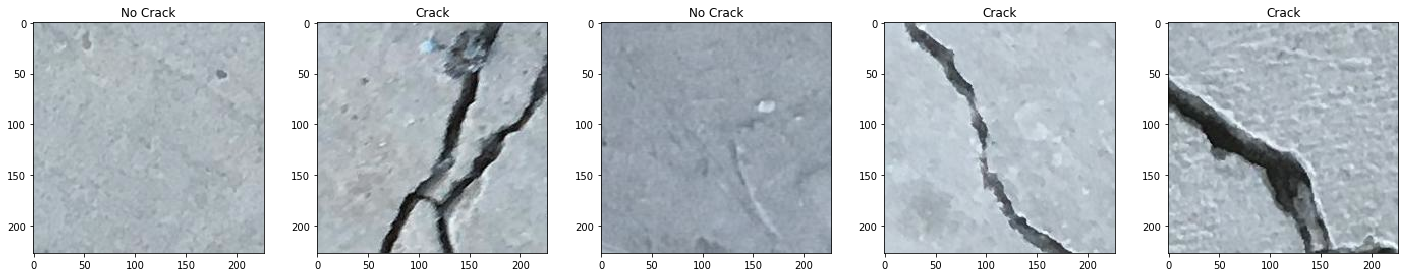

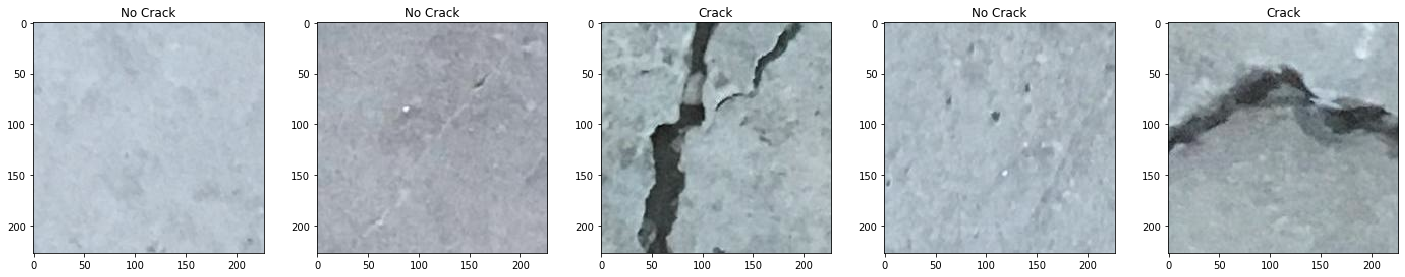

In [17]:
vis_im_hq_8k = getHighQualityVisualizationImages('8')

predictions = model_8k.predict(transformed_visualization_data_8k)
pred_class_arr = np.array(predictions).round()
counter = 0
for i in range(2):
    fig = plt.figure(figsize=(50, 50))
    for j in range(5):
        axisarr = fig.add_subplot(10, 10, j+1)
        axisarr.imshow(vis_im_hq_8k[counter])
        if(pred_class_arr[counter] == 0):
            axisarr.set_title('Crack')
        else:
            axisarr.set_title('No Crack')
        counter += 1

# First let's work with 16K images
## 8K of which are with cracks and 8K of which are without cracks

In [18]:
#let's get data of 16k images of which 8k are with cracks and 8k without cracks
dic_16k = getDataDic('16')
print(len(dic_16k['train_crack']), len(dic_16k['train_uncrack']), len(dic_16k['test_crack']), len(dic_16k['test_uncrack']),
      len(dic_16k['validation_crack']), len(dic_16k['validation_uncrack']), len(dic_16k['visualization_crack']))

5600 5600 1200 1200 1195 1195 10


In [19]:
#spearate training, testing, validation and visualization images from dictionary of whole images
training_images_16k, testing_images_16k, validation_images_16k, visualization_images_16k, y_train_16k, y_test_16k, y_validation_16k = transformDataToApplyPca(dic_16k)
print('Training images = ', len(training_images_16k), ' ', len(y_train_16k))
print('Testing images = ', len(testing_images_16k), ' ', len(y_test_16k))
print('Validation images = ', len(validation_images_16k), ' ', len(y_validation_16k))
print('Visualization images = ', len(visualization_images_16k))

Training images =  11200   11200
Testing images =  2400   2400
Validation images =  2390   2390
Visualization images =  10


#### Let's Visualize Training Images before applying PCA

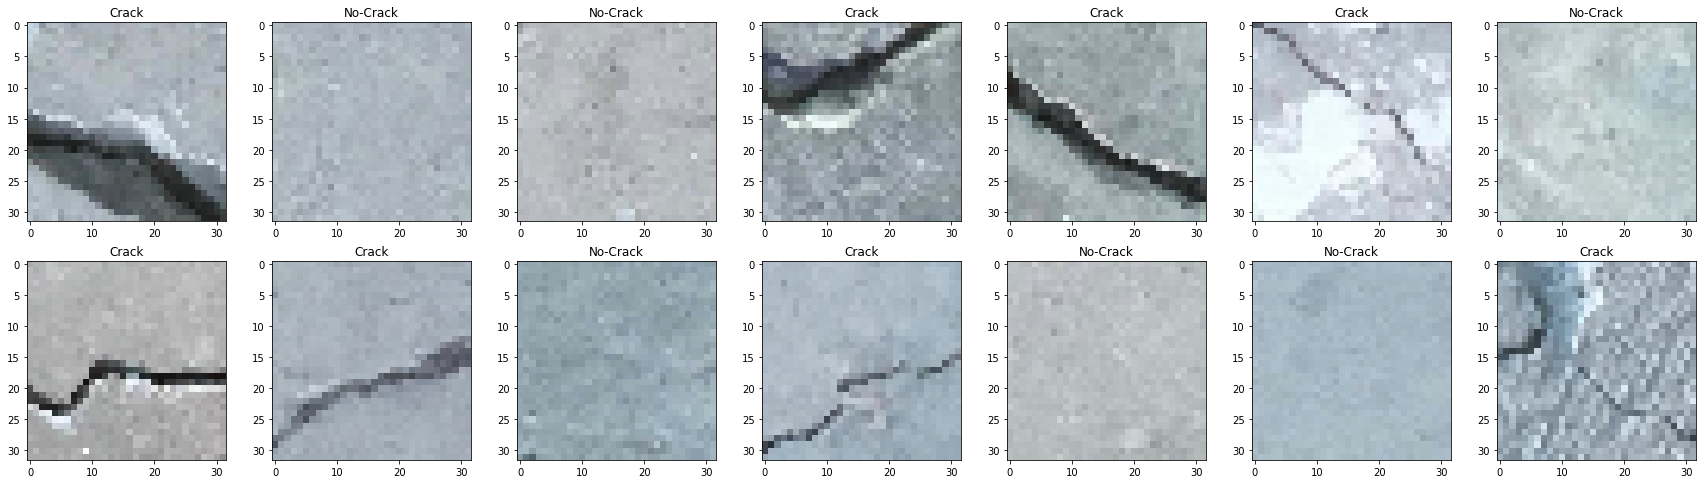

In [20]:
fig = plt.figure(figsize=(30, 30))
for i in range(0, 14, 1):
    ax = fig.add_subplot(7, 7, i+1)
    ax.imshow(training_images_16k[i])
    if(y_train_16k[i] == 0):
        ax.set_title('Crack')
    else:
        ax.set_title('No-Crack')
plt.show()

In [21]:
training_data_16k, testing_data_16k, validation_data_16k, visualization_data_16k = convertImagesDataFrom3dTo1d(training_images_16k, testing_images_16k, validation_images_16k, visualization_images_16k)


start_time_16k = time.time()
transformed_training_data_16k, transformed_testing_data_16k, transformed_validation_data_16k, transformed_visualization_data_16k = applyPcaAndFindSuitableK(training_data_16k, testing_data_16k, validation_data_16k, visualization_data_16k)
finish_time_16k = time.time()
time_taken_16k = finish_time_16k - start_time_16k
print('PCA applied in {:.0f}m {:.0f}s'.format(time_taken_16k // 60, time_taken_16k % 60))


transformed_training_data_16k, transformed_testing_data_16k, transformed_validation_data_16k, transformed_visualization_data_16k = addExtraDimForConv1D(transformed_training_data_16k, transformed_testing_data_16k, transformed_validation_data_16k, transformed_visualization_data_16k)
print('Number of features which contains 99% of total information : ', transformed_training_data_16k.shape[1])

PCA applied in 0m 23s
Number of features which contains 99% of total information :  831


In [22]:
model_16k = getModel(transformed_training_data_16k.shape[1])
model_16k.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 827, 6)            36        
_________________________________________________________________
average_pooling1d_3 (Average (None, 413, 6)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 409, 16)           496       
_________________________________________________________________
average_pooling1d_4 (Average (None, 204, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 204, 16)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 102, 16)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1632)             

In [23]:
start_time_16k = time.time() 
verbose, epochs, batch_size = 0, 15, 32
model_16k.fit(
    transformed_training_data_16k,
    y_train_16k,
    epochs=epochs,
    validation_data=(transformed_validation_data_16k, y_validation_16k)
)
finish_time_16k = time.time()
time_taken_16k = finish_time_16k - start_time_16k
print('\n')
print('Training complete in {:.0f}m {:.0f}s'.format(time_taken_16k // 60, time_taken_16k % 60))

Train on 11200 samples, validate on 2390 samples
Epoch 1/15
11200/11200 [==============================] - 2s 181us/step - loss: 0.3429 - accuracy: 0.8894 - precision_2: 0.9124 - recall_2: 0.8614 - val_loss: 0.1782 - val_accuracy: 0.9389 - val_precision_2: 0.9146 - val_recall_2: 0.9682
Epoch 2/15
11200/11200 [==============================] - 2s 151us/step - loss: 0.1319 - accuracy: 0.9551 - precision_2: 0.9578 - recall_2: 0.9521 - val_loss: 0.1629 - val_accuracy: 0.9418 - val_precision_2: 0.9043 - val_recall_2: 0.9883
Epoch 3/15
11200/11200 [==============================] - 2s 151us/step - loss: 0.1124 - accuracy: 0.9609 - precision_2: 0.9620 - recall_2: 0.9596 - val_loss: 0.1086 - val_accuracy: 0.9682 - val_precision_2: 0.9819 - val_recall_2: 0.9540
Epoch 4/15
11200/11200 [==============================] - 2s 151us/step - loss: 0.0888 - accuracy: 0.9689 - precision_2: 0.9701 - recall_2: 0.9677 - val_loss: 0.1115 - val_accuracy: 0.9590 - val_precision_2: 0.9315 - val_recall_2: 0.9908

In [24]:
_, accuracy_16k, precision_16k, recall_16k = model_16k.evaluate(transformed_testing_data_16k, y_test_16k, batch_size=batch_size, verbose=verbose)
print(' accuracy_16K : ', accuracy_16k, '\n', 'precision_16K : ', precision_16k, '\n', 'recall_16K : ', recall_16k)

 accuracy_16K :  0.9649999737739563 
 precision_16K :  0.9449760913848877 
 recall_16K :  0.987500011920929


#### VISUALISING PREDICTIONS OF MODEL TRAINED ON 16K IMAGES

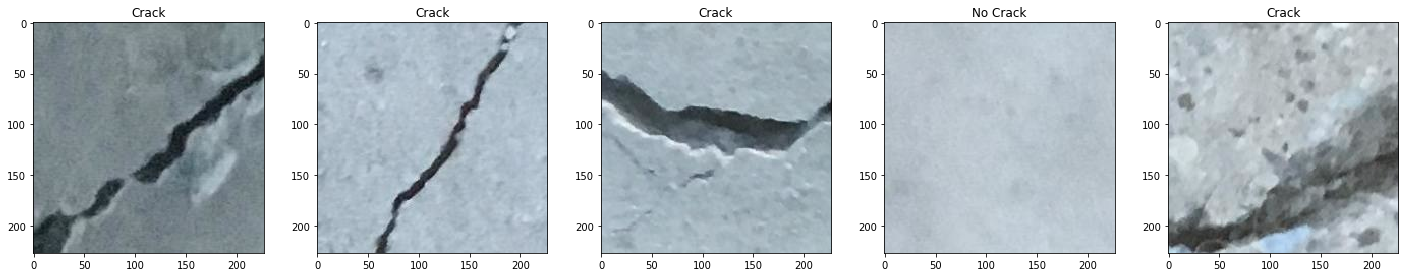

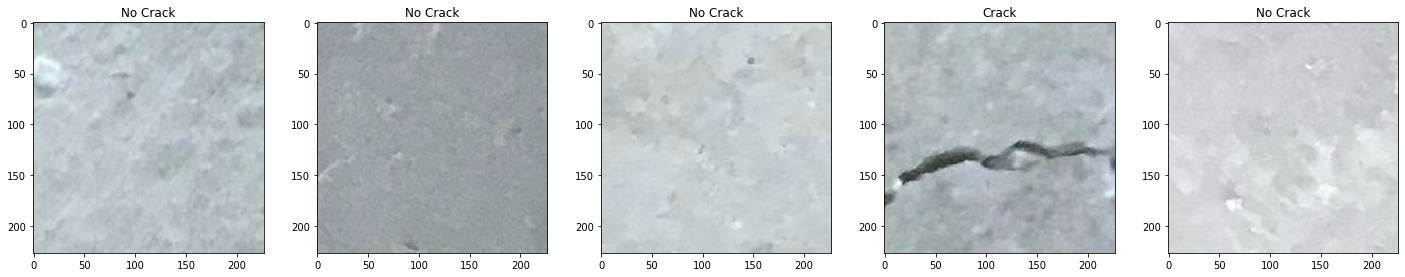

In [25]:
vis_im_hq_16k = getHighQualityVisualizationImages('16')

predictions_16k = model_16k.predict(transformed_visualization_data_16k)
pred_class_arr_16k = np.array(predictions_16k).round()
counter = 0
for i in range(2):
    fig = plt.figure(figsize=(50, 50))
    for j in range(5):
        axisarr = fig.add_subplot(10, 10, j+1)
        axisarr.imshow(vis_im_hq_16k[counter])
        if(pred_class_arr_16k[counter] == 0):
            axisarr.set_title('Crack')
        else:
            axisarr.set_title('No Crack')
        counter += 1

# First let's work with 24K images
## 12K of which are with cracks and 12K of which are without cracks

In [26]:
#let's get data of 24k images of which 8k are with cracks and 8k without cracks
dic_24k = getDataDic('24')
print(len(dic_24k['train_crack']), len(dic_24k['train_uncrack']), len(dic_24k['test_crack']), len(dic_24k['test_uncrack']),
      len(dic_24k['validation_crack']), len(dic_24k['validation_uncrack']), len(dic_24k['visualization_crack']))

8400 8400 1800 1800 1795 1795 10


In [27]:
#spearate training, testing, validation and visualization images from dictionary of whole images
training_images_24k, testing_images_24k, validation_images_24k, visualization_images_24k, y_train_24k, y_test_24k, y_validation_24k = transformDataToApplyPca(dic_24k)
print('Training images = ', len(training_images_24k), ' ', len(y_train_24k))
print('Testing images = ', len(testing_images_24k), ' ', len(y_test_24k))
print('Validation images = ', len(validation_images_24k), ' ', len(y_validation_24k))
print('Visualization images = ', len(visualization_images_24k))

Training images =  16800   16800
Testing images =  3600   3600
Validation images =  3590   3590
Visualization images =  10


#### Let's Visualize Training Images before applying PCA

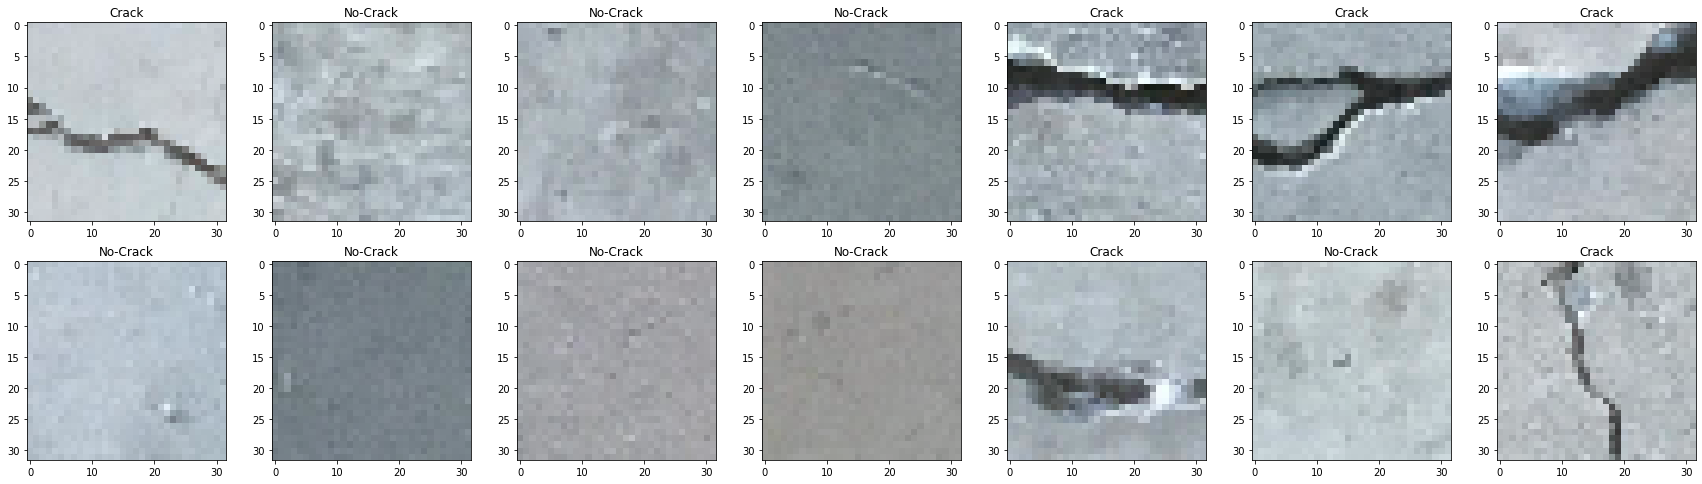

In [28]:
fig = plt.figure(figsize=(30, 30))
for i in range(0, 14, 1):
    ax = fig.add_subplot(7, 7, i+1)
    ax.imshow(training_images_24k[i])
    if(y_train_24k[i] == 0):
        ax.set_title('Crack')
    else:
        ax.set_title('No-Crack')
plt.show()

In [29]:
training_data_24k, testing_data_24k, validation_data_24k, visualization_data_24k = convertImagesDataFrom3dTo1d(training_images_24k, testing_images_24k, validation_images_24k, visualization_images_24k)


start_time_24k = time.time()
transformed_training_data_24k, transformed_testing_data_24k, transformed_validation_data_24k, transformed_visualization_data_24k = applyPcaAndFindSuitableK(training_data_24k, testing_data_24k, validation_data_24k, visualization_data_24k)
finish_time_24k = time.time()
time_taken_24k = finish_time_24k - start_time_24k
print('PCA applied in {:.0f}m {:.0f}s'.format(time_taken_24k // 60, time_taken_24k % 60))


transformed_training_data_24k, transformed_testing_data_24k, transformed_validation_data_24k, transformed_visualization_data_24k = addExtraDimForConv1D(transformed_training_data_24k, transformed_testing_data_24k, transformed_validation_data_24k, transformed_visualization_data_24k)
print('Number of features which contains 99% of total information : ', transformed_training_data_24k.shape[1])

PCA applied in 0m 34s
Number of features which contains 99% of total information :  846


In [30]:
model_24k = getModel(transformed_training_data_24k.shape[1])
model_24k.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 842, 6)            36        
_________________________________________________________________
average_pooling1d_5 (Average (None, 421, 6)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 417, 16)           496       
_________________________________________________________________
average_pooling1d_6 (Average (None, 208, 16)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 208, 16)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 104, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1664)             

In [31]:
start_time_24k = time.time() 
verbose, epochs, batch_size = 0, 15, 32
model_24k.fit(
    transformed_training_data_24k,
    y_train_24k,
    epochs=epochs,
    validation_data=(transformed_validation_data_24k, y_validation_24k)
)
finish_time_24k = time.time()
time_taken_24k = finish_time_24k - start_time_24k
print('\n')
print('Training complete in {:.0f}m {:.0f}s'.format(time_taken_24k // 60, time_taken_24k % 60))

Train on 16800 samples, validate on 3590 samples
Epoch 1/15
16800/16800 [==============================] - 3s 189us/step - loss: 0.2337 - accuracy: 0.9182 - precision_3: 0.9317 - recall_3: 0.9025 - val_loss: 0.1490 - val_accuracy: 0.9543 - val_precision_3: 0.9331 - val_recall_3: 0.9788
Epoch 2/15
16800/16800 [==============================] - 3s 176us/step - loss: 0.1142 - accuracy: 0.9576 - precision_3: 0.9593 - recall_3: 0.9557 - val_loss: 0.1395 - val_accuracy: 0.9515 - val_precision_3: 0.9171 - val_recall_3: 0.9928
Epoch 3/15
16800/16800 [==============================] - 3s 177us/step - loss: 0.0917 - accuracy: 0.9672 - precision_3: 0.9658 - recall_3: 0.9687 - val_loss: 0.1048 - val_accuracy: 0.9621 - val_precision_3: 0.9382 - val_recall_3: 0.9894
Epoch 4/15
16800/16800 [==============================] - 3s 172us/step - loss: 0.0835 - accuracy: 0.9685 - precision_3: 0.9681 - recall_3: 0.9688 - val_loss: 0.0839 - val_accuracy: 0.9708 - val_precision_3: 0.9543 - val_recall_3: 0.9889

In [32]:
_, accuracy_24k, precision_24k, recall_24k = model_24k.evaluate(transformed_testing_data_24k, y_test_24k, batch_size=batch_size, verbose=verbose)
print(' accuracy_24K : ', accuracy_24k, '\n', 'precision_24K : ', precision_24k, '\n', 'recall_24K : ', recall_24k)

 accuracy_24K :  0.9780555367469788 
 precision_24K :  0.9715068340301514 
 recall_24K :  0.9850000143051147


#### VISUALISING PREDICTIONS OF MODEL TRAINED ON 24K IMAGES

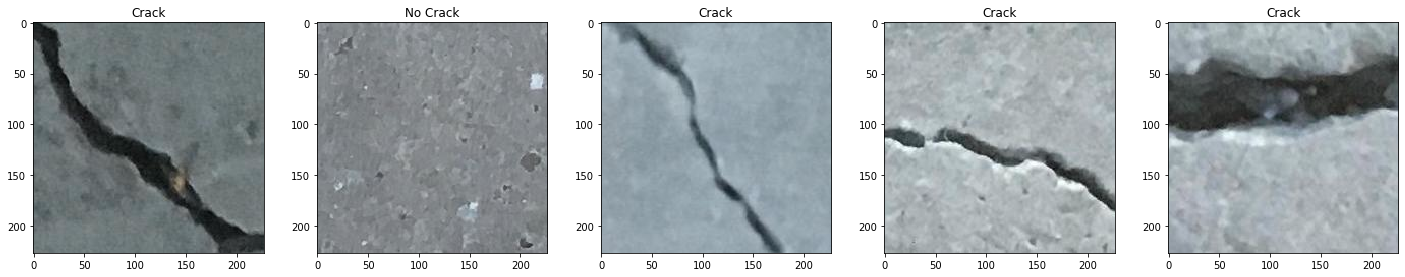

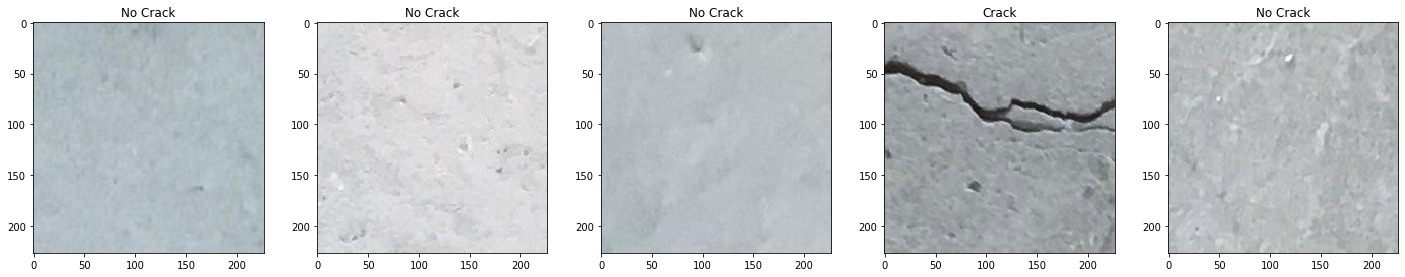

In [33]:
vis_im_hq_24k = getHighQualityVisualizationImages('24')

predictions_24k = model_24k.predict(transformed_visualization_data_24k)
pred_class_arr_24k = np.array(predictions_24k).round()
counter = 0
for i in range(2):
    fig = plt.figure(figsize=(50, 50))
    for j in range(5):
        axisarr = fig.add_subplot(10, 10, j+1)
        axisarr.imshow(vis_im_hq_24k[counter])
        if(pred_class_arr_24k[counter] == 0):
            axisarr.set_title('Crack')
        else:
            axisarr.set_title('No Crack')
        counter += 1

# First let's work with 32K images
## 16K of which are with cracks and 16K of which are without cracks

In [34]:
#let's get data of 32k images of which 16k are with cracks and 16k without cracks
dic_32k = getDataDic('32')
print(len(dic_32k['train_crack']), len(dic_32k['train_uncrack']), len(dic_32k['test_crack']), len(dic_32k['test_uncrack']),
      len(dic_32k['validation_crack']), len(dic_32k['validation_uncrack']), len(dic_32k['visualization_crack']))

11200 11200 2400 2400 2395 2395 10


In [35]:
#spearate training, testing, validation and visualization images from dictionary of whole images
training_images_32k, testing_images_32k, validation_images_32k, visualization_images_32k, y_train_32k, y_test_32k, y_validation_32k = transformDataToApplyPca(dic_32k)
print('Training images = ', len(training_images_32k), ' ', len(y_train_32k))
print('Testing images = ', len(testing_images_32k), ' ', len(y_test_32k))
print('Validation images = ', len(validation_images_32k), ' ', len(y_validation_32k))
print('Visualization images = ', len(visualization_images_32k))

Training images =  22400   22400
Testing images =  4800   4800
Validation images =  4790   4790
Visualization images =  10


#### Let's Visualize Training Images before applying PCA

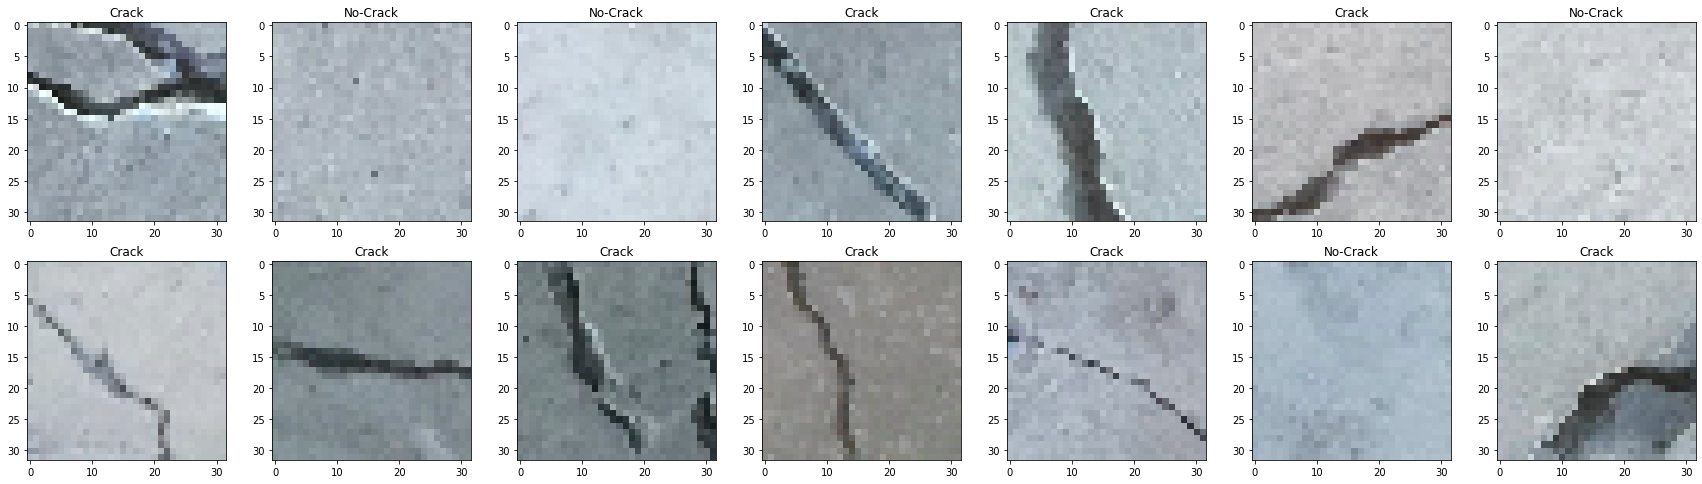

In [36]:
fig = plt.figure(figsize=(30, 30))
for i in range(0, 14, 1):
    ax = fig.add_subplot(7, 7, i+1)
    ax.imshow(training_images_32k[i])
    if(y_train_32k[i] == 0):
        ax.set_title('Crack')
    else:
        ax.set_title('No-Crack')
plt.show()

In [37]:
training_data_32k, testing_data_32k, validation_data_32k, visualization_data_32k = convertImagesDataFrom3dTo1d(training_images_32k, testing_images_32k, validation_images_32k, visualization_images_32k)


start_time_32k = time.time()
transformed_training_data_32k, transformed_testing_data_32k, transformed_validation_data_32k, transformed_visualization_data_32k = applyPcaAndFindSuitableK(training_data_32k, testing_data_32k, validation_data_32k, visualization_data_32k)
finish_time_32k = time.time()
time_taken_32k = finish_time_32k - start_time_32k
print('PCA applied in {:.0f}m {:.0f}s'.format(time_taken_32k // 60, time_taken_32k % 60))


transformed_training_data_32k, transformed_testing_data_32k, transformed_validation_data_32k, transformed_visualization_data_32k = addExtraDimForConv1D(transformed_training_data_32k, transformed_testing_data_32k, transformed_validation_data_32k, transformed_visualization_data_32k)
print('Number of features which contains 99% of total information : ', transformed_training_data_32k.shape[1])

PCA applied in 0m 38s
Number of features which contains 99% of total information :  854


In [38]:
model_32k = getModel(transformed_training_data_32k.shape[1])
model_32k.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 850, 6)            36        
_________________________________________________________________
average_pooling1d_7 (Average (None, 425, 6)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 421, 16)           496       
_________________________________________________________________
average_pooling1d_8 (Average (None, 210, 16)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 210, 16)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 105, 16)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1680)             

In [39]:
start_time_32k = time.time() 
verbose, epochs, batch_size = 0, 15, 32
model_32k.fit(
    transformed_training_data_32k,
    y_train_32k,
    epochs=epochs,
    validation_data=(transformed_validation_data_32k, y_validation_32k)
)
finish_time_32k = time.time()
time_taken_32k = finish_time_32k - start_time_32k
print('\n')
print('Training complete in {:.0f}m {:.0f}s'.format(time_taken_32k // 60, time_taken_32k % 60))

Train on 22400 samples, validate on 4790 samples
Epoch 1/15
22400/22400 [==============================] - 4s 172us/step - loss: 0.2560 - accuracy: 0.9203 - precision_4: 0.9365 - recall_4: 0.9018 - val_loss: 0.1155 - val_accuracy: 0.9599 - val_precision_4: 0.9505 - val_recall_4: 0.9704
Epoch 2/15
22400/22400 [==============================] - 3s 156us/step - loss: 0.1056 - accuracy: 0.9617 - precision_4: 0.9633 - recall_4: 0.9601 - val_loss: 0.0777 - val_accuracy: 0.9745 - val_precision_4: 0.9842 - val_recall_4: 0.9645
Epoch 3/15
22400/22400 [==============================] - 4s 158us/step - loss: 0.0884 - accuracy: 0.9675 - precision_4: 0.9685 - recall_4: 0.9664 - val_loss: 0.0777 - val_accuracy: 0.9685 - val_precision_4: 0.9535 - val_recall_4: 0.9850
Epoch 4/15
22400/22400 [==============================] - 4s 157us/step - loss: 0.0818 - accuracy: 0.9725 - precision_4: 0.9702 - recall_4: 0.9748 - val_loss: 0.1095 - val_accuracy: 0.9572 - val_precision_4: 0.9257 - val_recall_4: 0.9942

In [40]:
_, accuracy_32k, precision_32k, recall_32k = model_32k.evaluate(transformed_testing_data_32k, y_test_32k, batch_size=batch_size, verbose=verbose)
print(' accuracy_32K : ', accuracy_32k, '\n', 'precision_32K : ', precision_32k, '\n', 'recall_32K : ', recall_32k)

 accuracy_32K :  0.9762499928474426 
 precision_32K :  0.9695973992347717 
 recall_32K :  0.9833333492279053


#### VISUALISING PREDICTIONS OF MODEL TRAINED ON 32K IMAGES

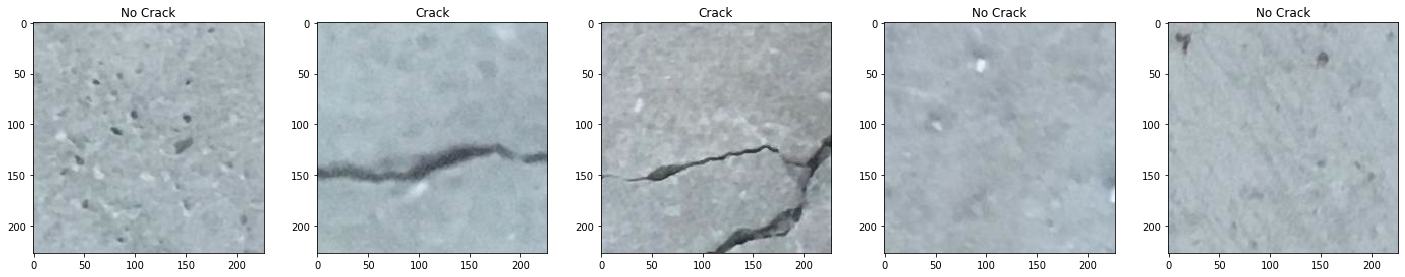

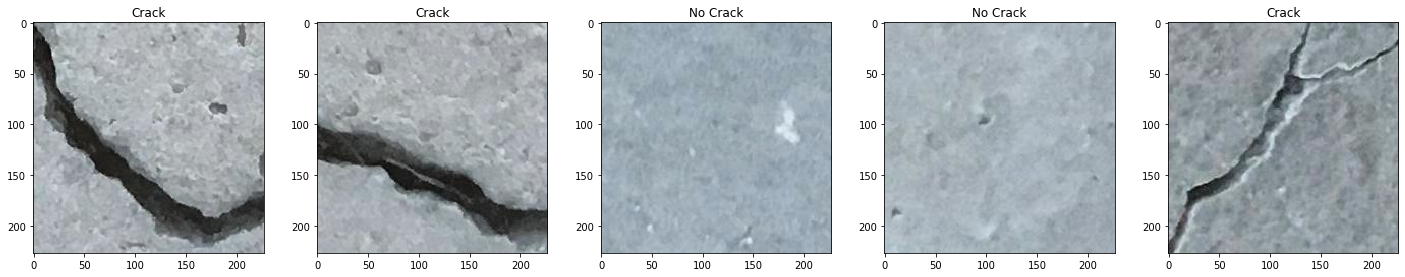

In [41]:
vis_im_hq_32k = getHighQualityVisualizationImages('32')

predictions_32k = model_32k.predict(transformed_visualization_data_32k)
pred_class_arr_32k = np.array(predictions_32k).round()
counter = 0
for i in range(2):
    fig = plt.figure(figsize=(50, 50))
    for j in range(5):
        axisarr = fig.add_subplot(10, 10, j+1)
        axisarr.imshow(vis_im_hq_32k[counter])
        if(pred_class_arr_32k[counter] == 0):
            axisarr.set_title('Crack')
        else:
            axisarr.set_title('No Crack')
        counter += 1

# First let's work with 40K images
## 20K of which are with cracks and 20K of which are without cracks

In [42]:
#let's get data of 32k images of which 16k are with cracks and 16k without cracks
dic_40k = getDataDic('40')
print(len(dic_40k['train_crack']), len(dic_40k['train_uncrack']), len(dic_40k['test_crack']), len(dic_40k['test_uncrack']),
      len(dic_40k['validation_crack']), len(dic_40k['validation_uncrack']), len(dic_40k['visualization_crack']))

14000 14000 3000 3000 2995 2995 10


In [43]:
#spearate training, testing, validation and visualization images from dictionary of whole images
training_images_40k, testing_images_40k, validation_images_40k, visualization_images_40k, y_train_40k, y_test_40k, y_validation_40k = transformDataToApplyPca(dic_40k)
print('Training images = ', len(training_images_40k), ' ', len(y_train_40k))
print('Testing images = ', len(testing_images_40k), ' ', len(y_test_40k))
print('Validation images = ', len(validation_images_40k), ' ', len(y_validation_40k))
print('Visualization images = ', len(visualization_images_40k))

Training images =  28000   28000
Testing images =  6000   6000
Validation images =  5990   5990
Visualization images =  10


#### Let's Visualize Training Images before applying PCA

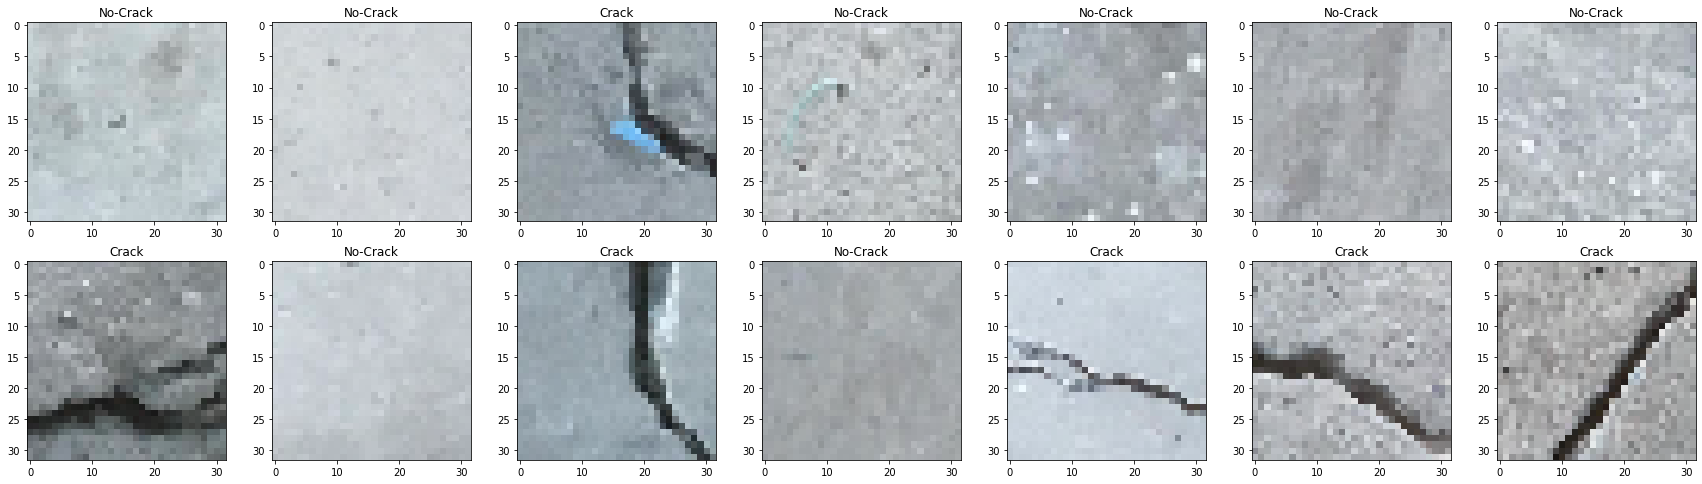

In [44]:
fig = plt.figure(figsize=(30, 30))
for i in range(0, 14, 1):
    ax = fig.add_subplot(7, 7, i+1)
    ax.imshow(training_images_40k[i])
    if(y_train_40k[i] == 0):
        ax.set_title('Crack')
    else:
        ax.set_title('No-Crack')
plt.show()

In [45]:
training_data_40k, testing_data_40k, validation_data_40k, visualization_data_40k = convertImagesDataFrom3dTo1d(training_images_40k, testing_images_40k, validation_images_40k, visualization_images_40k)


start_time_40k = time.time()
transformed_training_data_40k, transformed_testing_data_40k, transformed_validation_data_40k, transformed_visualization_data_40k = applyPcaAndFindSuitableK(training_data_40k, testing_data_40k, validation_data_40k, visualization_data_40k)
finish_time_40k = time.time()
time_taken_40k = finish_time_40k - start_time_40k
print('PCA applied in {:.0f}m {:.0f}s'.format(time_taken_40k // 60, time_taken_40k % 60))


transformed_training_data_40k, transformed_testing_data_40k, transformed_validation_data_40k, transformed_visualization_data_40k = addExtraDimForConv1D(transformed_training_data_40k, transformed_testing_data_40k, transformed_validation_data_40k, transformed_visualization_data_40k)
print('Number of features which contains 99% of total information : ', transformed_training_data_40k.shape[1])

PCA applied in 0m 45s
Number of features which contains 99% of total information :  859


In [46]:
model_40k = getModel(transformed_training_data_40k.shape[1])
model_40k.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 855, 6)            36        
_________________________________________________________________
average_pooling1d_9 (Average (None, 427, 6)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 423, 16)           496       
_________________________________________________________________
average_pooling1d_10 (Averag (None, 211, 16)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 211, 16)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 105, 16)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1680)             

In [47]:
start_time_40k = time.time() 
verbose, epochs, batch_size = 0, 15, 32
model_40k.fit(
    transformed_training_data_40k,
    y_train_40k,
    epochs=epochs,
    validation_data=(transformed_validation_data_40k, y_validation_40k)
)
finish_time_40k = time.time()
time_taken_40k = finish_time_40k - start_time_40k
print('\n')
print('Training complete in {:.0f}m {:.0f}s'.format(time_taken_40k // 60, time_taken_40k % 60))

Train on 28000 samples, validate on 5990 samples
Epoch 1/15
28000/28000 [==============================] - 5s 171us/step - loss: 0.2007 - accuracy: 0.9334 - precision_5: 0.9419 - recall_5: 0.9238 - val_loss: 0.0833 - val_accuracy: 0.9738 - val_precision_5: 0.9717 - val_recall_5: 0.9760
Epoch 2/15
28000/28000 [==============================] - 4s 159us/step - loss: 0.0950 - accuracy: 0.9661 - precision_5: 0.9661 - recall_5: 0.9661 - val_loss: 0.0884 - val_accuracy: 0.9691 - val_precision_5: 0.9506 - val_recall_5: 0.9896
Epoch 3/15
28000/28000 [==============================] - 4s 159us/step - loss: 0.0841 - accuracy: 0.9693 - precision_5: 0.9682 - recall_5: 0.9704 - val_loss: 0.0678 - val_accuracy: 0.9766 - val_precision_5: 0.9697 - val_recall_5: 0.9840
Epoch 4/15
28000/28000 [==============================] - 4s 159us/step - loss: 0.0797 - accuracy: 0.9720 - precision_5: 0.9700 - recall_5: 0.9741 - val_loss: 0.0663 - val_accuracy: 0.9786 - val_precision_5: 0.9695 - val_recall_5: 0.9883

In [48]:
_, accuracy_40k, precision_40k, recall_40k = model_40k.evaluate(transformed_testing_data_40k, y_test_40k, batch_size=batch_size, verbose=verbose)
print(' accuracy_40K : ', accuracy_40k, '\n', 'precision_40K : ', precision_40k, '\n', 'recall_40K : ', recall_40k)

 accuracy_40K :  0.9804999828338623 
 precision_40K :  0.9809809923171997 
 recall_40K :  0.9800000190734863


#### VISUALISING PREDICTIONS OF MODEL TRAINED ON 40K IMAGES

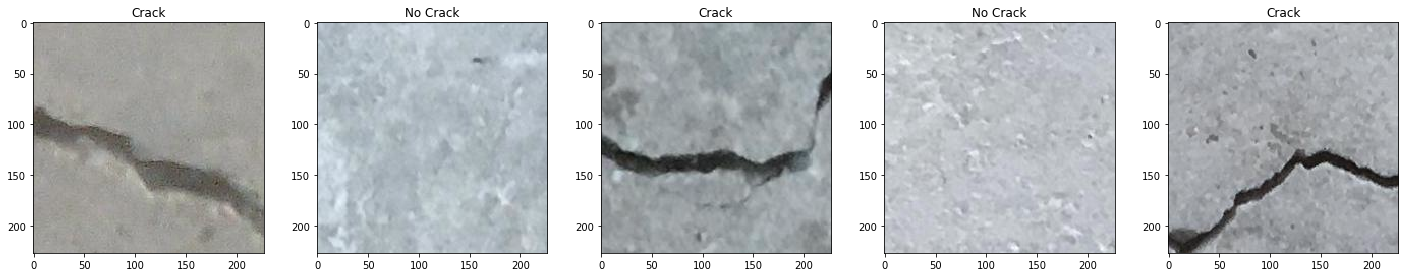

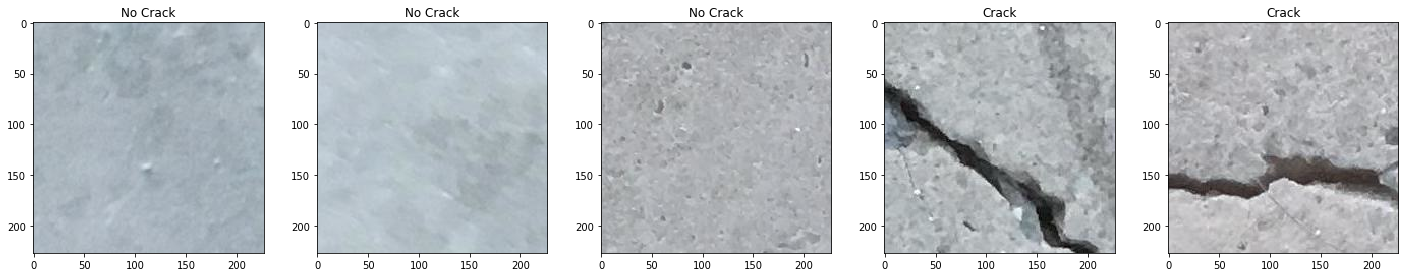

In [49]:
vis_im_hq_40k = getHighQualityVisualizationImages('40')

predictions_40k = model_40k.predict(transformed_visualization_data_40k)
pred_class_arr_40k = np.array(predictions_40k).round()
counter = 0
for i in range(2):
    fig = plt.figure(figsize=(50, 50))
    for j in range(5):
        axisarr = fig.add_subplot(10, 10, j+1)
        axisarr.imshow(vis_im_hq_40k[counter])
        if(pred_class_arr_40k[counter] == 0):
            axisarr.set_title('Crack')
        else:
            axisarr.set_title('No Crack')
        counter += 1